# Enhanced Explained singel model
This origin comming from https://www.kaggle.com/code/lblhandsome/optiver-robust-best-single-model/notebook

In [1]:
from pathlib import Path
import os
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import gc  # Garbage collection for memory management
import os  # Operating system-related functions
import time  # Time-related functions
import warnings  # Handling warnings
from itertools import combinations  # For creating combinations of elements
from warnings import simplefilter  # Simplifying warning handling

# 📦 Importing machine learning libraries
import joblib  # For saving and loading models
import lightgbm as lgb  # LightGBM gradient boosting framework
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation and analysis
from sklearn.metrics import mean_absolute_error  # Metric for evaluation
from sklearn.model_selection import KFold, TimeSeriesSplit  # Cross-validation techniques

# 🤐 Disable warnings to keep the code clean
warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

max_lookback = np.nan  # Maximum lookback (not specified)
split_day = 435  # Split day for time series data

warnings.filterwarnings("ignore")

PREV_MAX = 80
IS_DEBUG = True
# For kaggle environment
if os.environ.get("KAGGLE_DATA_PROXY_TOKEN") != None:
    BASE_OUTPUT_PATH = Path(f'/kaggle/working')
    BASE_INPUT_PATH = Path(f'/kaggle/input/optiver-trading-at-the-close')
    TRAIN_FILE = Path(f'{BASE_INPUT_PATH}/train.csv')
    TEST_FILE = Path(f'{BASE_INPUT_PATH}/test.csv')
    IS_LOCAL = False
    IS_OFFLINE = False
    IS_TRAIN = True
    IS_INFER = True

    stopping_rounds = 10 # early_stopping用コールバック関数
    num_boost_round = 2000 # 計算回数
    num_folds = 5 # クロスバリデーションの分割数

    lgb_params = {
        'objective': 'regression',                # 目的関数の種類。ここでは回帰タスクを指定
        'metric': 'mae',                          # 評価指標。ここでは平均絶対誤差を使用
        'boosting_type': 'gbdt',                  # ブースティングタイプ。勾配ブースティング決定木
        "n_estimators": 6000,                        # ブースティングに使用する木の数。多いほど性能が向上するが計算コストが増加
        "num_leaves": 256,                         # 木に存在する最大の葉の数。大きい値は精度を向上させるが過学習のリスクが増加
        "subsample": 0.6,                         # 各木のトレーニングに使用されるデータの割合。過学習を防ぐために一部のデータをサンプリング
        "colsample_bytree": 0.8,                  # 木を構築する際に使用される特徴の割合。特徴のサブセットを使用し過学習を防ぐ
        "learning_rate": 0.00871,                 # 学習率。小さい値は堅牢なモデルを生成するが収束に時間がかかる
        'max_depth': 11,                           # 木の最大の深さ。深い木は複雑なモデルを作成するが過学習のリスクがある
        "n_jobs": -1,                              # 並列処理に使用するCPUコアの数。大きい値は計算速度を向上させる
        "device": 'gpu',                         # トレーニングに使用するデバイス（CPUまたはGPU）
        "verbosity": -1,                          # LightGBMのログ出力のレベル。-1はログを出力しないことを意味する
        "importance_type": "gain",                # 特徴重要度を計算する際の指標。"gain"は分割による平均情報利得
        'lambda_l1': 0.5,                         # L1正則化項の係数。過学習を防ぐためにモデルの複雑さにペナルティを課す
        'lambda_l2': 0.5,                         # L2正則化項の係数。同じく過学習を防ぐ
    }


# For local environment
else:
    BASE_OUTPUT_PATH = Path(f'../output')
    BASE_INPUT_PATH = Path(f'../kaggle/input/optiver-trading-at-the-close')
    TRAIN_FILE = Path(f'{BASE_INPUT_PATH}/train.csv')
    TEST_FILE = Path(f'{BASE_INPUT_PATH}/test.csv')
    SAMPLE_SUBMISSION_FILE = Path(f'{BASE_INPUT_PATH}/sample_submission.csv')
    REVEALED_TARGETS_FILE = Path(f'{BASE_INPUT_PATH}/revealed_targets.csv')
    IS_LOCAL = True
    IS_OFFLINE = False
    IS_TRAIN = True
    IS_INFER = True
    TARGET_STOCK_IDS = [0]

    # For training

    stopping_rounds = 1 # early_stopping用コールバック関数
    num_boost_round = 2 # 計算回数
    num_folds = 5 # クロスバリデーションの分割数

    lgb_params = {
        'objective': 'regression',                # 目的関数の種類。ここでは回帰タスクを指定
        'metric': 'mae',                          # 評価指標。ここでは平均絶対誤差を使用
        'boosting_type': 'gbdt',                  # ブースティングタイプ。勾配ブースティング決定木
        "n_estimators": 8,                        # ブースティングに使用する木の数。多いほど性能が向上するが計算コストが増加
        "num_leaves": 16,                         # 木に存在する最大の葉の数。大きい値は精度を向上させるが過学習のリスクが増加
        "subsample": 0.6,                         # 各木のトレーニングに使用されるデータの割合。過学習を防ぐために一部のデータをサンプリング
        "colsample_bytree": 0.8,                  # 木を構築する際に使用される特徴の割合。特徴のサブセットを使用し過学習を防ぐ
        "learning_rate": 0.00871,                 # 学習率。小さい値は堅牢なモデルを生成するが収束に時間がかかる
        'max_depth': 8,                           # 木の最大の深さ。深い木は複雑なモデルを作成するが過学習のリスクがある
        "n_jobs": 4,                              # 並列処理に使用するCPUコアの数。大きい値は計算速度を向上させる
        "device": 'cpu',                         # トレーニングに使用するデバイス（CPUまたはGPU）
        "verbosity": -1,                          # LightGBMのログ出力のレベル。-1はログを出力しないことを意味する
        "importance_type": "gain",                # 特徴重要度を計算する際の指標。"gain"は分割による平均情報利得
        'lambda_l1': 0.5,                         # L1正則化項の係数。過学習を防ぐためにモデルの複雑さにペナルティを課す
        'lambda_l2': 0.5,                         # L2正則化項の係数。同じく過学習を防ぐ
    }


print(f"BASE_OUTPUT_PATH: {BASE_OUTPUT_PATH}")
print(f"BASE_INPUT_PATH: {BASE_INPUT_PATH}")
print(f"TRAIN_FILE: {TRAIN_FILE}")
print(f"TEST_FILE: {TEST_FILE}")
print(f"IS_OFFLINE: {IS_OFFLINE}")
print(f"IS_LOCAL: {IS_LOCAL}")
print(f"IS_TRAIN: {IS_TRAIN}")
print(f"IS_INFER: {IS_INFER}")


BASE_OUTPUT_PATH: ../output
BASE_INPUT_PATH: ../kaggle/input/optiver-trading-at-the-close
TRAIN_FILE: ../kaggle/input/optiver-trading-at-the-close/train.csv
TEST_FILE: ../kaggle/input/optiver-trading-at-the-close/test.csv
IS_OFFLINE: False
IS_LOCAL: True
IS_TRAIN: True
IS_INFER: True


# Functions

In [2]:
from typing import Sequence, Tuple

import pandas as pd

# for local execution
class MockApi:
    def __init__(self):
        '''
        YOU MUST UPDATE THE FIRST THREE LINES of this method.
        They've been intentionally left in an invalid state.

        Variables to set:
            input_paths: a list of two or more paths to the csv files to be served
            group_id_column: the column that identifies which groups of rows the API should serve.
                A call to iter_test serves all rows of all dataframes with the current group ID value.
            export_group_id_column: if true, the dataframes iter_test serves will include the group_id_column values.
        '''
        self.input_paths: Sequence[str] = [TEST_FILE, REVEALED_TARGETS_FILE, SAMPLE_SUBMISSION_FILE]
        self.group_id_column: str = 'time_id'
        self.export_group_id_column: bool = True
        # iter_test is only designed to support at least two dataframes, such as test and sample_submission
        assert len(self.input_paths) >= 2

        self._status = 'initialized'
        self.predictions = []

    def iter_test(self) -> Tuple[pd.DataFrame]:
        '''
        Loads all of the dataframes specified in self.input_paths,
        then yields all rows in those dataframes that equal the current self.group_id_column value.
        '''
        if self._status != 'initialized':

            raise Exception('WARNING: the real API can only iterate over `iter_test()` once.')

        dataframes = []
        for pth in self.input_paths:
            dataframes.append(pd.read_csv(pth, low_memory=False))
        group_order = dataframes[0][self.group_id_column].drop_duplicates().tolist()
        dataframes = [df.set_index(self.group_id_column) for df in dataframes]

        for group_id in group_order:
            self._status = 'prediction_needed'
            current_data = []
            for df in dataframes:
                cur_df = df.loc[group_id].copy()
                # returning single line dataframes from df.loc requires special handling
                if not isinstance(cur_df, pd.DataFrame):
                    cur_df = pd.DataFrame({a: b for a, b in zip(cur_df.index.values, cur_df.values)}, index=[group_id])
                    cur_df.index.name = self.group_id_column
                cur_df = cur_df.reset_index(drop=not(self.export_group_id_column))
                current_data.append(cur_df)
            yield tuple(current_data)

            while self._status != 'prediction_received':
                print('You must call `predict()` successfully before you can continue with `iter_test()`', flush=True)
                yield None

        with open('submission.csv', 'w') as f_open:
            pd.concat(self.predictions).to_csv(f_open, index=False)
        self._status = 'finished'

    def predict(self, user_predictions: pd.DataFrame):
        '''
        Accepts and stores the user's predictions and unlocks iter_test once that is done
        '''
        if self._status == 'finished':
            raise Exception('You have already made predictions for the full test set.')
        if self._status != 'prediction_needed':
            raise Exception('You must get the next test sample from `iter_test()` first.')
        if not isinstance(user_predictions, pd.DataFrame):
            raise Exception('You must provide a DataFrame.')

        self.predictions.append(user_predictions)
        self._status = 'prediction_received'


def make_env():
    return MockApi()

In [3]:
# 🧹 Function to reduce memory usage of a Pandas DataFrame
def reduce_mem_usage(df, verbose=0):
    """
    Iterate through all numeric columns of a dataframe and modify the data type
    to reduce memory usage.
    """
    
    # 📏 Calculate the initial memory usage of the DataFrame
    start_mem = df.memory_usage().sum() / 1024**2

    # 🔄 Iterate through each column in the DataFrame
    for col in df.columns:
        col_type = df[col].dtype

        # Check if the column's data type is not 'object' (i.e., numeric)
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            # Check if the column's data type is an integer
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                # Check if the column's data type is a float
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)

    # ℹ️ Provide memory optimization information if 'verbose' is True
    if verbose:
        logger.info(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        logger.info(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        logger.info(f"Decreased by {decrease:.2f}%")

    # 🔄 Return the DataFrame with optimized memory usage
    return df

In [4]:
# 🏎️ Import Numba for just-in-time (JIT) compilation and parallel processing
from numba import njit, prange

# 📊 Function to compute triplet imbalance in parallel using Numba
@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))

    # 🔁 Loop through all combinations of triplets
    for i in prange(num_combinations):
        a, b, c = comb_indices[i]
        
        # 🔁 Loop through rows of the DataFrame
        for j in range(num_rows):
            max_val = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_val = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_val = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_val - max_val
            
            # 🚫 Prevent division by zero
            if mid_val == min_val:
                imbalance_features[j, i] = np.nan
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val)

    return imbalance_features

# 📈 Function to calculate triplet imbalance for given price data and a DataFrame
def calculate_triplet_imbalance_numba(price, df):
    # Convert DataFrame to numpy array for Numba compatibility
    df_values = df[price].values
    comb_indices = [(price.index(a), price.index(b), price.index(c)) for a, b, c in combinations(price, 3)]

    # Calculate the triplet imbalance using the Numba-optimized function
    features_array = compute_triplet_imbalance(df_values, comb_indices)

    # Create a DataFrame from the results
    columns = [f"{a}_{b}_{c}_imb2" for a, b, c in combinations(price, 3)]
    features = pd.DataFrame(features_array, columns=columns)

    return features

In [5]:
# 📊 Function to generate imbalance features
def imbalance_features(df):
    if not IS_LOCAL:
        import cudf
        df = cudf.from_pandas(df)
    
    # Define lists of price and size-related column names
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]

    # V1 features
    # Calculate various features using Pandas eval function
    df["volume"] = df.eval("ask_size + bid_size")
    df["mid_price"] = df.eval("ask_price + bid_price")/2
    df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
    df["matched_imbalance"] = df.eval("imbalance_size-matched_size")/df.eval("matched_size+imbalance_size")
    df["size_imbalance"] = df.eval("bid_size / ask_size")
    
    # Create features for pairwise price imbalances
    for c in combinations(prices, 2):
        df[f"{c[0]}_{c[1]}_imb"] = df.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]})")
        
    # V2 features
    # Calculate additional features
    df["imbalance_momentum"] = df.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / df['matched_size']
    df["price_spread"] = df["ask_price"] - df["bid_price"]
    df["spread_intensity"] = df.groupby(['stock_id'])['price_spread'].diff()
    df['price_pressure'] = df['imbalance_size'] * (df['ask_price'] - df['bid_price'])
    df['market_urgency'] = df['price_spread'] * df['liquidity_imbalance']
    df['depth_pressure'] = (df['ask_size'] - df['bid_size']) * (df['far_price'] - df['near_price'])
    
    # Calculate various statistical aggregation features
    
        
    # V3 features
    # Calculate shifted and return features for specific columns
    for col in ['matched_size', 'imbalance_size', 'reference_price', 'imbalance_buy_sell_flag']:
        for window in [1, 2, 3, 10]:
            df[f"{col}_shift_{window}"] = df.groupby('stock_id')[col].shift(window)
            df[f"{col}_ret_{window}"] = df.groupby('stock_id')[col].pct_change(window)
    
    # Calculate diff features for specific columns
    for col in ['ask_price', 'bid_price', 'ask_size', 'bid_size']:
        for window in [1, 2, 3, 10]:
            df[f"{col}_diff_{window}"] = df.groupby("stock_id")[col].diff(window)
    if not IS_LOCAL:
        df = df.to_pandas()
    # Replace infinite values with 0
    return df.replace([np.inf, -np.inf], 0)

def numba_imb_features(df):
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
    
    for func in ["mean", "std", "skew", "kurt"]:
        df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
        df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)
        
    # Calculate triplet imbalance features using the Numba-optimized function
    for c in [['ask_price', 'bid_price', 'wap', 'reference_price'], sizes]:
        triplet_feature = calculate_triplet_imbalance_numba(c, df)
        df[triplet_feature.columns] = triplet_feature.values
    return df

# 📅 Function to generate time and stock-related features
def other_features(df):
    df["dow"] = df["date_id"] % 5  # Day of the week
    df["seconds"] = df["seconds_in_bucket"] % 60  # Seconds
    df["minute"] = df["seconds_in_bucket"] // 60  # Minutes

    # Map global features to the DataFrame
    for key, value in global_stock_id_feats.items():
        df[f"global_{key}"] = df["stock_id"].map(value.to_dict())

    return df

# 📈 Function to generate normalized features
global_population_wap = None
global_population_mathch_balance = None
def generate_normalized_features(df, is_train):
    global global_population_wap
    global global_population_mathch_balance
    print("generate_normalized_features")
    df['match_balance'] = ( df['matched_size']  + (df['imbalance_buy_sell_flag'] * df['imbalance_size'])) / df['matched_size']
    if is_train:
        global_population_wap = df['wap'].describe()
        global_population_mathch_balance = df['match_balance'].describe()
    else:
        print("use exsisting global_population")
    df['normalized_wap'] = (df['wap'] - global_population_wap['mean']) / global_population_wap['std']
    df['normalized_match_balance'] = (df['match_balance'] - global_population_mathch_balance['mean']) / global_population_mathch_balance['std']
    return df

def cal_vix(df, group_key, target_col, period):
    return df.groupby(group_key)[target_col].transform(lambda x: np.log(x).diff().rolling(period).std())

def generate_historical_features(df, is_train):
    for col in ['wap', 'match_balance']:
        for window in [1, 2, 3, 10]:
            col_name = f"{col}_diff_{window}"
            df[col_name] = df.groupby("stock_id")[col].diff(window)
            #df[col_name] = df[col_name].fillna(0)  # NaNを0で置き換える
        for period in [5]:
            col_name = f"{col}_vix_{period}"
            df[col_name] = cal_vix(df, ['stock_id', 'date_id'], col, period)

    df = df.replace([np.inf, -np.inf], 0)
    return df

# 🚀 Function to generate all features by combining imbalance and other features
def generate_all_features(df, is_train):
    # Select relevant columns for feature generation
    cols = [c for c in df.columns if c not in ["row_id", "time_id", "target"]]
    df = df[cols]
    
    # Generate imbalance features
    df = imbalance_features(df)
    df = numba_imb_features(df)
    df = generate_normalized_features(df, is_train)
    df = generate_historical_features(df, is_train)
    # Generate time and stock-related features
    #df = other_features(df)
    gc.collect()  # Perform garbage collection to free up memory
    
    # Select and return the generated features
    feature_name = [i for i in df.columns if i not in ["row_id", "target", "time_id", "date_id"]]

    return df[feature_name]

# Generationg train dataset

In [6]:
def load_train_dataset():
    df = pd.read_csv(TRAIN_FILE)
    # 🧹 Remove rows with missing values in the "target" column
    df = df.dropna(subset=["target"])
    # 🔁 Reset the index of the DataFrame and apply the changes in place
    df.reset_index(drop=True, inplace=True)
    return df


In [7]:
# Check if the code is running in offline or online mode
df_tmp_train = load_train_dataset()

if IS_LOCAL:
    # In local mode, stock id TARGET_STOCK_ID is used for training
    df_tmp_train = df_tmp_train[df_tmp_train["stock_id"].isin(TARGET_STOCK_IDS)]

if IS_OFFLINE:
    # In offline mode, split the data into training and validation sets based on the split_day
    df_train = df_tmp_train[df_tmp_train["date_id"] <= split_day]
    df_valid = df_tmp_train[df_tmp_train["date_id"] > split_day]
    
    # Display a message indicating offline mode and the shapes of the training and validation sets
    print("Offline mode")
    print(f"train : {df_train.shape}, valid : {df_valid.shape}")
else:
    # In online mode, use the entire dataset for training
    df_train = df_tmp_train
    
    # Display a message indicating online mode
    print("Online mode")


Online mode


In [8]:
if IS_TRAIN:
    global_stock_id_feats = {
        "median_size": df_train.groupby("stock_id")["bid_size"].median() + df_train.groupby("stock_id")["ask_size"].median(),
        "std_size": df_train.groupby("stock_id")["bid_size"].std() + df_train.groupby("stock_id")["ask_size"].std(),
        "ptp_size": df_train.groupby("stock_id")["bid_size"].max() - df_train.groupby("stock_id")["bid_size"].min(),
        "median_price": df_train.groupby("stock_id")["bid_price"].median() + df_train.groupby("stock_id")["ask_price"].median(),
        "std_price": df_train.groupby("stock_id")["bid_price"].std() + df_train.groupby("stock_id")["ask_price"].std(),
        "ptp_price": df_train.groupby("stock_id")["bid_price"].max() - df_train.groupby("stock_id")["ask_price"].min(),
    }
    if IS_OFFLINE:
        df_train_feats = generate_all_features(df_train, True)
        print("Build Train Feats Finished.")
        df_valid_feats = generate_all_features(df_valid, True)
        print("Build Valid Feats Finished.")
        df_valid_feats = reduce_mem_usage(df_valid_feats, True)
    else:
        df_train_feats = generate_all_features(df_train, True)
        print("Build Online Train Feats Finished.")

    df_train_feats = reduce_mem_usage(df_train_feats)

generate_normalized_features
Build Online Train Feats Finished.


## global_stock_id_feats

In [9]:
df_global_stock_id_feats = pd.DataFrame(global_stock_id_feats)
df_global_stock_id_feats.head()

,median_size,std_size,ptp_size,median_price,std_price,ptp_price
stock_id,,,,,,
0,42739.16,132986.92003,5898989.29,1.999695,0.003353,0.017414


## df_train_feats

In [10]:
df_train_feats.head()

,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,...,wap_diff_1,wap_diff_2,wap_diff_3,wap_diff_10,wap_vix_5,match_balance_diff_1,match_balance_diff_2,match_balance_diff_3,match_balance_diff_10,match_balance_vix_5
0,0,0,3180602.750,1,0.999812,13380277.0,NaN,NaN,0.999812,60651.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
191,0,10,1299772.750,1,1.000026,15261107.0,NaN,NaN,0.999812,13996.500000,...,-0.000108,NaN,NaN,NaN,NaN,-0.152539,NaN,NaN,NaN,NaN
382,0,20,1299772.750,1,0.999919,15261107.0,NaN,NaN,0.999812,4665.500000,...,-0.000050,-0.000158,NaN,NaN,NaN,0.000000,-0.152539,NaN,NaN,NaN
573,0,30,1299772.750,1,1.000133,15261107.0,NaN,NaN,1.000026,55998.000000,...,0.000243,0.000193,0.000085,NaN,NaN,0.000000,0.000000,-0.152539,NaN,NaN
764,0,40,1218204.375,1,1.000455,15342675.0,NaN,NaN,1.000241,14655.950195,...,0.000232,0.000475,0.000425,NaN,NaN,-0.005769,-0.005769,-0.005769,NaN,NaN


# Model Training

In [11]:
# 📦 Import necessary libraries
import numpy as np
#import lightgbm as lgb
import optuna.integration.lightgbm as lgb
from sklearn.metrics import mean_absolute_error
import gc
import os
from sklearn.model_selection import KFold

def train_model(train_x, train_y, val_x, val_y):
    trains = lgb.Dataset(train_x, train_y)
    valids = lgb.Dataset(val_x, val_y, reference=trains)

    verbose_eval = 0
    model = lgb.train(
        lgb_params,
        trains,
        valid_sets=valids, 
        num_boost_round=2,
        callbacks=[
                lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=True),
                lgb.log_evaluation(verbose_eval)
        ]
    )
    return model

# 📋 Get feature names
feature_name = list(df_train_feats.columns)
print(f"Feature length = {len(feature_name)}")
print(f"Features: {feature_name}")

# 🔄 Set up cross-validation parameters
fold_size = 480 // num_folds
gap = 5

# 📊 Initialize lists to store models and scores
models = []
scores = []

# 💾 Set model save path
model_save_path = 'modelitos_para_despues' 
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

# 📅 Get date IDs from the training data
date_ids = df_train['date_id'].values

# 🔄 Loop over folds for cross-validation
for i in range(num_folds):
    start = i * fold_size
    end = start + fold_size
    if i < num_folds - 1:  # No need to purge after the last fold
        purged_start = end - 2
        purged_end = end + gap + 2
        train_indices = (date_ids >= start) & (date_ids < purged_start) | (date_ids > purged_end)
    else:
        train_indices = (date_ids >= start) & (date_ids < end)

    test_indices = (date_ids >= end) & (date_ids < end + fold_size)

    # 📊 Create fold-specific training and validation sets
    df_fold_train = df_train_feats[train_indices]
    df_fold_train_target = df_train['target'][train_indices]
    df_fold_valid = df_train_feats[test_indices]
    df_fold_valid_target = df_train['target'][test_indices]

    print(f"Fold {i+1} Model Training")
    print(f"Start: {start}")
    print(f"End: {end}")
    print(f"train_indices: {train_indices}")
    print(f"test_indices: {test_indices}")

    model = train_model(df_fold_train[feature_name], df_fold_train_target, df_fold_valid[feature_name], df_fold_valid_target)
    
    models.append(model)

    # 📊 Evaluate model performance on the validation set
    fold_predictions = model.predict(df_fold_valid[feature_name])

    # For debug
    y_valid_df = pd.DataFrame(df_fold_valid_target, columns=["target"])
    y_valid_df["pred"] = fold_predictions
    y_valid_df.to_csv('filename.csv', index=False)

    # calculate score
    fold_score = mean_absolute_error(fold_predictions, df_fold_valid_target)
    scores.append(fold_score)
    print(f"Fold {i+1} MAE: {fold_score}")

    # 🔄 Free up memory by deleting fold-specific variables
    del df_fold_train, df_fold_train_target, df_fold_valid, df_fold_valid_target
    gc.collect()


# 🚂 Train the final model on the entire dataset
final_model = train_model(df_train_feats[feature_name], df_train['target'], df_train_feats[feature_name], df_train['target'])

# 📄 Append the final model to the list of models
models.append(final_model)

# ℹ️ Now 'models' holds the trained models for each fold and 'scores' holds the validation scores
print(f"Average MAE across all folds: {np.mean(scores)}")

[I 2023-11-21 21:31:54,664] A new study created in memory with name: no-name-94d703b1-b6cb-476b-9328-db8bb6361f7c


Feature length = 116
Features: ['stock_id', 'seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap', 'volume', 'mid_price', 'liquidity_imbalance', 'matched_imbalance', 'size_imbalance', 'reference_price_far_price_imb', 'reference_price_near_price_imb', 'reference_price_ask_price_imb', 'reference_price_bid_price_imb', 'reference_price_wap_imb', 'far_price_near_price_imb', 'far_price_ask_price_imb', 'far_price_bid_price_imb', 'far_price_wap_imb', 'near_price_ask_price_imb', 'near_price_bid_price_imb', 'near_price_wap_imb', 'ask_price_bid_price_imb', 'ask_price_wap_imb', 'bid_price_wap_imb', 'imbalance_momentum', 'price_spread', 'spread_intensity', 'price_pressure', 'market_urgency', 'depth_pressure', 'matched_size_shift_1', 'matched_size_ret_1', 'matched_size_shift_2', 'matched_size_ret_2', 'matched_size_shift_3', 'matched_size_ret_3', 'matched_size_shift_10', '

feature_fraction, val_score: 5.025525:  14%|#4        | 1/7 [00:00<00:01,  4.33it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.02553


feature_fraction, val_score: 5.025525:  29%|##8       | 2/7 [00:00<00:01,  4.63it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.02591
Training until validation scores don't improve for 1 rounds


feature_fraction, val_score: 5.024659:  57%|#####7    | 4/7 [00:00<00:00,  5.06it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.02466
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.0267


feature_fraction, val_score: 5.024659:  71%|#######1  | 5/7 [00:00<00:00,  5.22it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.02625
Training until validation scores don't improve for 1 rounds


feature_fraction, val_score: 5.024659: 100%|##########| 7/7 [00:01<00:00,  5.05it/s]


Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.02555
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.02691


num_leaves, val_score: 5.014425:   5%|5         | 1/20 [00:00<00:04,  4.30it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01442


num_leaves, val_score: 5.014425:  10%|#         | 2/20 [00:00<00:04,  4.38it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01442


num_leaves, val_score: 5.014425:  15%|#5        | 3/20 [00:00<00:04,  4.17it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01442


num_leaves, val_score: 5.014425:  20%|##        | 4/20 [00:00<00:03,  4.24it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01442


num_leaves, val_score: 5.014425:  25%|##5       | 5/20 [00:01<00:03,  4.33it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01442


num_leaves, val_score: 5.014425:  30%|###       | 6/20 [00:01<00:03,  4.33it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01442


num_leaves, val_score: 5.014425:  35%|###5      | 7/20 [00:01<00:02,  4.46it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01796


num_leaves, val_score: 5.014425:  40%|####      | 8/20 [00:01<00:02,  4.42it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01442


num_leaves, val_score: 5.014425:  45%|####5     | 9/20 [00:02<00:02,  4.12it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01442


num_leaves, val_score: 5.014425:  50%|#####     | 10/20 [00:02<00:02,  3.94it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01442


num_leaves, val_score: 5.014425:  55%|#####5    | 11/20 [00:02<00:02,  3.51it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01442


num_leaves, val_score: 5.014425:  60%|######    | 12/20 [00:03<00:02,  3.10it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01442


num_leaves, val_score: 5.014425:  65%|######5   | 13/20 [00:03<00:02,  2.75it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01442


num_leaves, val_score: 5.014425:  70%|#######   | 14/20 [00:03<00:02,  2.82it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01442


num_leaves, val_score: 5.014425:  75%|#######5  | 15/20 [00:04<00:01,  2.84it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01442


num_leaves, val_score: 5.014425:  80%|########  | 16/20 [00:04<00:01,  2.92it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01442


num_leaves, val_score: 5.014425:  85%|########5 | 17/20 [00:05<00:01,  2.76it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01442


num_leaves, val_score: 5.014425:  90%|######### | 18/20 [00:05<00:00,  2.83it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01442


num_leaves, val_score: 5.014425:  95%|#########5| 19/20 [00:05<00:00,  2.93it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01442


num_leaves, val_score: 5.014425: 100%|##########| 20/20 [00:06<00:00,  3.30it/s]


Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01442


bagging, val_score: 5.014425:  10%|#         | 1/10 [00:00<00:02,  3.07it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01973


bagging, val_score: 5.014425:  20%|##        | 2/10 [00:00<00:02,  3.16it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01526


bagging, val_score: 5.014425:  30%|###       | 3/10 [00:01<00:02,  2.86it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.0166


bagging, val_score: 5.014425:  40%|####      | 4/10 [00:01<00:02,  2.89it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01501


bagging, val_score: 5.014425:  50%|#####     | 5/10 [00:01<00:01,  3.02it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01977


bagging, val_score: 5.014425:  60%|######    | 6/10 [00:02<00:01,  2.94it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.0149


bagging, val_score: 5.014425:  70%|#######   | 7/10 [00:02<00:01,  2.86it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01674


bagging, val_score: 5.014425:  80%|########  | 8/10 [00:02<00:00,  2.87it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01672


bagging, val_score: 5.014425:  90%|######### | 9/10 [00:03<00:00,  2.92it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01672


bagging, val_score: 5.014425: 100%|##########| 10/10 [00:03<00:00,  2.88it/s]


Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01559


feature_fraction_stage2, val_score: 5.014394:  17%|#6        | 1/6 [00:00<00:01,  2.89it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01439


feature_fraction_stage2, val_score: 5.014394:  33%|###3      | 2/6 [00:00<00:01,  2.96it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01476


feature_fraction_stage2, val_score: 5.014394:  50%|#####     | 3/6 [00:01<00:01,  2.82it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.0146


feature_fraction_stage2, val_score: 5.014394:  67%|######6   | 4/6 [00:01<00:00,  2.67it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01549


feature_fraction_stage2, val_score: 5.014394:  83%|########3 | 5/6 [00:02<00:00,  2.27it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01551


feature_fraction_stage2, val_score: 5.014394: 100%|##########| 6/6 [00:02<00:00,  2.57it/s]


Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01476


regularization_factors, val_score: 5.014394:   5%|5         | 1/20 [00:00<00:05,  3.52it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01444


regularization_factors, val_score: 5.014394:  10%|#         | 2/20 [00:00<00:07,  2.50it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01523


regularization_factors, val_score: 5.014394:  15%|#5        | 3/20 [00:01<00:07,  2.31it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01444
Training until validation scores don't improve for 1 rounds


regularization_factors, val_score: 5.014394:  20%|##        | 4/20 [00:02<00:08,  1.83it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01525


regularization_factors, val_score: 5.014315:  25%|##5       | 5/20 [00:02<00:08,  1.71it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01431
Training until validation scores don't improve for 1 rounds


regularization_factors, val_score: 5.014315:  30%|###       | 6/20 [00:03<00:08,  1.66it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01444


regularization_factors, val_score: 5.014315:  35%|###5      | 7/20 [00:03<00:06,  1.95it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01431


regularization_factors, val_score: 5.014315:  40%|####      | 8/20 [00:03<00:05,  2.22it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01431


regularization_factors, val_score: 5.014315:  45%|####5     | 9/20 [00:04<00:04,  2.45it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01432


regularization_factors, val_score: 5.014314:  50%|#####     | 10/20 [00:04<00:03,  2.57it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01431


regularization_factors, val_score: 5.014314:  55%|#####5    | 11/20 [00:04<00:03,  2.83it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01431


regularization_factors, val_score: 5.014314:  60%|######    | 12/20 [00:05<00:02,  3.09it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01432


regularization_factors, val_score: 5.014314:  65%|######5   | 13/20 [00:05<00:02,  3.31it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01432


regularization_factors, val_score: 5.014314:  70%|#######   | 14/20 [00:05<00:01,  3.43it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01432


regularization_factors, val_score: 5.014314:  75%|#######5  | 15/20 [00:05<00:01,  3.56it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01432


regularization_factors, val_score: 5.014314:  80%|########  | 16/20 [00:06<00:01,  3.68it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01432


regularization_factors, val_score: 5.014314:  85%|########5 | 17/20 [00:06<00:00,  3.77it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01444


regularization_factors, val_score: 5.014314:  90%|######### | 18/20 [00:06<00:00,  3.80it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01433


regularization_factors, val_score: 5.014314:  95%|#########5| 19/20 [00:06<00:00,  3.82it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01444


regularization_factors, val_score: 5.014314: 100%|##########| 20/20 [00:07<00:00,  2.81it/s]


Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01444


min_child_samples, val_score: 5.014314:  20%|##        | 1/5 [00:00<00:00,  4.06it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.02161


min_child_samples, val_score: 5.014314:  40%|####      | 2/5 [00:00<00:00,  3.95it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01774


min_child_samples, val_score: 5.014314:  60%|######    | 3/5 [00:00<00:00,  3.97it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01545


min_child_samples, val_score: 5.011449:  80%|########  | 4/5 [00:01<00:00,  3.90it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.01145


min_child_samples, val_score: 5.009929: 100%|##########| 5/5 [00:01<00:00,  3.81it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 5.00993
Fold 1 MAE: 5.009928822164964



[I 2023-11-21 21:32:16,596] A new study created in memory with name: no-name-6b3ce1b8-c6f4-4cfd-9035-1da68c279a28


Fold 2 Model Training
Start: 96
End: 192
train_indices: [False False False ...  True  True  True]
test_indices: [False False False ... False False False]


feature_fraction, val_score: 4.981266:  14%|#4        | 1/7 [00:00<00:00,  6.57it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.98127


feature_fraction, val_score: 4.979157:  29%|##8       | 2/7 [00:00<00:00,  6.47it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.97916
Training until validation scores don't improve for 1 rounds


feature_fraction, val_score: 4.978899:  43%|####2     | 3/7 [00:00<00:00,  5.86it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.9789


feature_fraction, val_score: 4.978899:  57%|#####7    | 4/7 [00:00<00:00,  3.63it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.97936


feature_fraction, val_score: 4.978899:  71%|#######1  | 5/7 [00:01<00:00,  3.04it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.98034


feature_fraction, val_score: 4.978899:  86%|########5 | 6/7 [00:02<00:00,  2.22it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.98153


feature_fraction, val_score: 4.978899: 100%|##########| 7/7 [00:02<00:00,  2.74it/s]


Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.97914


num_leaves, val_score: 4.967812:   5%|5         | 1/20 [00:00<00:07,  2.60it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96781


num_leaves, val_score: 4.967812:  10%|#         | 2/20 [00:00<00:06,  2.84it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.97212


num_leaves, val_score: 4.967812:  15%|#5        | 3/20 [00:01<00:06,  2.69it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.97596


num_leaves, val_score: 4.967812:  20%|##        | 4/20 [00:01<00:05,  3.02it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96781


num_leaves, val_score: 4.967812:  25%|##5       | 5/20 [00:01<00:04,  3.40it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96781


num_leaves, val_score: 4.967812:  30%|###       | 6/20 [00:02<00:04,  2.97it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96781


num_leaves, val_score: 4.967812:  35%|###5      | 7/20 [00:02<00:04,  2.63it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96781


num_leaves, val_score: 4.967812:  40%|####      | 8/20 [00:02<00:03,  3.02it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96781


num_leaves, val_score: 4.967812:  45%|####5     | 9/20 [00:02<00:03,  3.38it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96781


num_leaves, val_score: 4.967812:  50%|#####     | 10/20 [00:03<00:02,  3.68it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96781


num_leaves, val_score: 4.967812:  55%|#####5    | 11/20 [00:03<00:02,  3.93it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96781


num_leaves, val_score: 4.967812:  60%|######    | 12/20 [00:03<00:01,  4.14it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96781


num_leaves, val_score: 4.967812:  65%|######5   | 13/20 [00:03<00:01,  4.30it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96781


num_leaves, val_score: 4.967812:  70%|#######   | 14/20 [00:04<00:01,  4.42it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96781


num_leaves, val_score: 4.967812:  75%|#######5  | 15/20 [00:04<00:01,  4.42it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96781


num_leaves, val_score: 4.967812:  80%|########  | 16/20 [00:04<00:00,  4.41it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96781


num_leaves, val_score: 4.967812:  85%|########5 | 17/20 [00:04<00:00,  4.36it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96781


num_leaves, val_score: 4.967812:  90%|######### | 18/20 [00:04<00:00,  4.17it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96801


num_leaves, val_score: 4.967812:  95%|#########5| 19/20 [00:05<00:00,  4.02it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96781


num_leaves, val_score: 4.967812: 100%|##########| 20/20 [00:05<00:00,  3.66it/s]


Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96781


bagging, val_score: 4.967812:  10%|#         | 1/10 [00:00<00:02,  4.28it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.97075


bagging, val_score: 4.967812:  20%|##        | 2/10 [00:00<00:01,  4.10it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.97758


bagging, val_score: 4.967812:  30%|###       | 3/10 [00:00<00:01,  3.81it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96781


bagging, val_score: 4.967812:  40%|####      | 4/10 [00:01<00:01,  3.76it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.97256


bagging, val_score: 4.967812:  50%|#####     | 5/10 [00:01<00:01,  3.25it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.97202


bagging, val_score: 4.967812:  60%|######    | 6/10 [00:01<00:01,  3.26it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.97075


bagging, val_score: 4.967812:  70%|#######   | 7/10 [00:02<00:00,  3.39it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.97467


bagging, val_score: 4.967812:  80%|########  | 8/10 [00:02<00:00,  3.47it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.97097


bagging, val_score: 4.967812:  90%|######### | 9/10 [00:02<00:00,  3.47it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.97237


bagging, val_score: 4.967812: 100%|##########| 10/10 [00:02<00:00,  3.59it/s]


Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.97199


feature_fraction_stage2, val_score: 4.967551:  17%|#6        | 1/6 [00:00<00:01,  4.46it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96755


feature_fraction_stage2, val_score: 4.967551:  33%|###3      | 2/6 [00:00<00:01,  3.28it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96805


feature_fraction_stage2, val_score: 4.967326:  50%|#####     | 3/6 [00:00<00:00,  3.53it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96733


feature_fraction_stage2, val_score: 4.967326:  67%|######6   | 4/6 [00:01<00:00,  3.58it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96773


feature_fraction_stage2, val_score: 4.966830:  83%|########3 | 5/6 [00:01<00:00,  3.76it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96683


feature_fraction_stage2, val_score: 4.966830: 100%|##########| 6/6 [00:01<00:00,  3.77it/s]


Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96787


regularization_factors, val_score: 4.966461:   5%|5         | 1/20 [00:00<00:05,  3.74it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96646


regularization_factors, val_score: 4.966461:  10%|#         | 2/20 [00:00<00:04,  3.65it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96646


regularization_factors, val_score: 4.966461:  15%|#5        | 3/20 [00:00<00:04,  3.75it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96646


regularization_factors, val_score: 4.966461:  20%|##        | 4/20 [00:01<00:04,  3.75it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96646


regularization_factors, val_score: 4.966461:  25%|##5       | 5/20 [00:01<00:03,  3.88it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96646


regularization_factors, val_score: 4.966461:  30%|###       | 6/20 [00:01<00:03,  4.00it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96646


regularization_factors, val_score: 4.966461:  35%|###5      | 7/20 [00:01<00:03,  4.05it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96646


regularization_factors, val_score: 4.966461:  40%|####      | 8/20 [00:02<00:02,  4.17it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96646


regularization_factors, val_score: 4.966461:  45%|####5     | 9/20 [00:02<00:02,  4.21it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96646


regularization_factors, val_score: 4.966461:  50%|#####     | 10/20 [00:02<00:02,  4.23it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96646


regularization_factors, val_score: 4.966461:  55%|#####5    | 11/20 [00:02<00:02,  4.30it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96646


regularization_factors, val_score: 4.966461:  60%|######    | 12/20 [00:02<00:01,  4.36it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96646


regularization_factors, val_score: 4.966461:  65%|######5   | 13/20 [00:03<00:01,  4.41it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96646


regularization_factors, val_score: 4.966461:  70%|#######   | 14/20 [00:03<00:01,  4.48it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96646


regularization_factors, val_score: 4.966461:  75%|#######5  | 15/20 [00:03<00:01,  4.55it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96646


regularization_factors, val_score: 4.966461:  80%|########  | 16/20 [00:03<00:00,  4.26it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96646


regularization_factors, val_score: 4.966461:  85%|########5 | 17/20 [00:04<00:00,  4.21it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96646


regularization_factors, val_score: 4.966461:  90%|######### | 18/20 [00:04<00:00,  4.16it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96646


regularization_factors, val_score: 4.966461:  95%|#########5| 19/20 [00:04<00:00,  3.90it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96646


regularization_factors, val_score: 4.966461: 100%|##########| 20/20 [00:04<00:00,  4.11it/s]


Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96646


min_child_samples, val_score: 4.966461:  20%|##        | 1/5 [00:00<00:00,  4.98it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.97501


min_child_samples, val_score: 4.962688:  40%|####      | 2/5 [00:00<00:00,  4.34it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96269


min_child_samples, val_score: 4.962688:  60%|######    | 3/5 [00:00<00:00,  4.31it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96385


min_child_samples, val_score: 4.962688:  80%|########  | 4/5 [00:00<00:00,  4.52it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.97239


min_child_samples, val_score: 4.962688: 100%|##########| 5/5 [00:01<00:00,  4.45it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.96894
Fold 2 MAE: 4.962687550607129



[I 2023-11-21 21:32:35,165] A new study created in memory with name: no-name-18480743-b487-4f7a-8ac1-670ca086e9cd


Fold 3 Model Training
Start: 192
End: 288
train_indices: [False False False ...  True  True  True]
test_indices: [False False False ... False False False]


feature_fraction, val_score: 4.172818:  14%|#4        | 1/7 [00:00<00:00,  8.20it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.17282


feature_fraction, val_score: 4.172408:  29%|##8       | 2/7 [00:00<00:00,  8.11it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.17241


feature_fraction, val_score: 4.172400:  43%|####2     | 3/7 [00:00<00:00,  8.30it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.1724


feature_fraction, val_score: 4.171023:  57%|#####7    | 4/7 [00:00<00:00,  8.12it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.17102


feature_fraction, val_score: 4.171023:  71%|#######1  | 5/7 [00:00<00:00,  7.65it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.1719


feature_fraction, val_score: 4.171023:  86%|########5 | 6/7 [00:00<00:00,  7.46it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.17265


feature_fraction, val_score: 4.171023: 100%|##########| 7/7 [00:00<00:00,  7.64it/s]


Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.17181


num_leaves, val_score: 4.171023:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 1 rounds


num_leaves, val_score: 4.160693:   5%|5         | 1/20 [00:00<00:03,  5.32it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16069
Training until validation scores don't improve for 1 rounds


num_leaves, val_score: 4.160693:  10%|#         | 2/20 [00:00<00:03,  5.34it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16069


num_leaves, val_score: 4.160693:  15%|#5        | 3/20 [00:00<00:03,  5.45it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16069
Training until validation scores don't improve for 1 rounds


num_leaves, val_score: 4.160693:  20%|##        | 4/20 [00:00<00:02,  6.09it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.1697
Training until validation scores don't improve for 1 rounds


num_leaves, val_score: 4.160693:  25%|##5       | 5/20 [00:00<00:02,  5.78it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16069
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16069


num_leaves, val_score: 4.160693:  35%|###5      | 7/20 [00:01<00:02,  5.07it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16069


num_leaves, val_score: 4.160693:  40%|####      | 8/20 [00:01<00:02,  4.95it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16083
Training until validation scores don't improve for 1 rounds


num_leaves, val_score: 4.160693:  45%|####5     | 9/20 [00:01<00:02,  5.02it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16069
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16069


num_leaves, val_score: 4.160693:  55%|#####5    | 11/20 [00:02<00:01,  5.02it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16082


num_leaves, val_score: 4.160693:  60%|######    | 12/20 [00:02<00:01,  4.99it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16069
Training until validation scores don't improve for 1 rounds


num_leaves, val_score: 4.160693:  65%|######5   | 13/20 [00:02<00:01,  5.02it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16069
Training until validation scores don't improve for 1 rounds


num_leaves, val_score: 4.160693:  70%|#######   | 14/20 [00:02<00:01,  4.99it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16069
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16069


num_leaves, val_score: 4.160693:  80%|########  | 16/20 [00:03<00:00,  4.83it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16069


num_leaves, val_score: 4.160693:  85%|########5 | 17/20 [00:03<00:00,  4.87it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16069
Training until validation scores don't improve for 1 rounds


num_leaves, val_score: 4.160693:  90%|######### | 18/20 [00:03<00:00,  4.93it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16069
Training until validation scores don't improve for 1 rounds


num_leaves, val_score: 4.160693:  95%|#########5| 19/20 [00:03<00:00,  4.93it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16069
Training until validation scores don't improve for 1 rounds


num_leaves, val_score: 4.160693: 100%|##########| 20/20 [00:03<00:00,  5.07it/s]


Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16069


bagging, val_score: 4.160693:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 1 rounds


bagging, val_score: 4.160693:  10%|#         | 1/10 [00:00<00:02,  3.85it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16184
Training until validation scores don't improve for 1 rounds


bagging, val_score: 4.160693:  20%|##        | 2/10 [00:00<00:01,  4.42it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16483
Training until validation scores don't improve for 1 rounds


bagging, val_score: 4.160693:  40%|####      | 4/10 [00:00<00:01,  5.00it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16072
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16813


bagging, val_score: 4.160693:  50%|#####     | 5/10 [00:01<00:00,  5.07it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16185
Training until validation scores don't improve for 1 rounds


bagging, val_score: 4.160693:  60%|######    | 6/10 [00:01<00:00,  5.19it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16498
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16296


bagging, val_score: 4.160693:  80%|########  | 8/10 [00:01<00:00,  5.21it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16352
Training until validation scores don't improve for 1 rounds


bagging, val_score: 4.160693:  90%|######### | 9/10 [00:01<00:00,  5.06it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16081
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16171


feature_fraction_stage2, val_score: 4.160693:  17%|#6        | 1/6 [00:00<00:00,  5.11it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16116
Training until validation scores don't improve for 1 rounds


feature_fraction_stage2, val_score: 4.160693:  33%|###3      | 2/6 [00:00<00:00,  4.96it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16186
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16163


feature_fraction_stage2, val_score: 4.160693:  67%|######6   | 4/6 [00:00<00:00,  5.17it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16146
Training until validation scores don't improve for 1 rounds


feature_fraction_stage2, val_score: 4.160481: 100%|##########| 6/6 [00:01<00:00,  5.21it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16048
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16066


[I 2023-11-21 21:32:43,208] Trial 42 finished with value: 4.160663479715657 and parameters: {'feature_fraction': 0.45199999999999996}. Best is trial 41 with value: 4.1604814411011555.
regularization_factors, val_score: 4.160481:   5%|5         | 1/20 [00:00<00:03,  5.06it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16113


regularization_factors, val_score: 4.160383:  10%|#         | 2/20 [00:00<00:03,  4.95it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16038


regularization_factors, val_score: 4.160372:  15%|#5        | 3/20 [00:00<00:03,  4.99it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16037
Training until validation scores don't improve for 1 rounds


regularization_factors, val_score: 4.160346:  25%|##5       | 5/20 [00:00<00:02,  5.23it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16042
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16035


regularization_factors, val_score: 4.160346:  30%|###       | 6/20 [00:01<00:02,  5.31it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16083
Training until validation scores don't improve for 1 rounds


regularization_factors, val_score: 4.160346:  40%|####      | 8/20 [00:01<00:02,  5.36it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16073
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16039


regularization_factors, val_score: 4.160346:  45%|####5     | 9/20 [00:01<00:02,  5.37it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16039
Training until validation scores don't improve for 1 rounds


regularization_factors, val_score: 4.160346:  55%|#####5    | 11/20 [00:02<00:01,  5.37it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16035
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16039


regularization_factors, val_score: 4.160346:  60%|######    | 12/20 [00:02<00:01,  5.35it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16035
Training until validation scores don't improve for 1 rounds


regularization_factors, val_score: 4.160346:  70%|#######   | 14/20 [00:02<00:01,  5.39it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16049
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16048


regularization_factors, val_score: 4.160346:  75%|#######5  | 15/20 [00:02<00:00,  5.42it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16048
Training until validation scores don't improve for 1 rounds


regularization_factors, val_score: 4.160346:  85%|########5 | 17/20 [00:03<00:00,  5.45it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16047
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.1605


regularization_factors, val_score: 4.160346:  90%|######### | 18/20 [00:03<00:00,  5.47it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16073
Training until validation scores don't improve for 1 rounds


regularization_factors, val_score: 4.160346: 100%|##########| 20/20 [00:03<00:00,  5.40it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16048
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16045


[I 2023-11-21 21:32:46,950] Trial 62 finished with value: 4.160454587044409 and parameters: {'lambda_l1': 0.73317621613568, 'lambda_l2': 8.751272095245859e-08}. Best is trial 47 with value: 4.1603455181153635.
min_child_samples, val_score: 4.160346:  20%|##        | 1/5 [00:00<00:00,  6.03it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16565
Training until validation scores don't improve for 1 rounds


min_child_samples, val_score: 4.160346:  40%|####      | 2/5 [00:00<00:00,  5.61it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16186
Training until validation scores don't improve for 1 rounds


min_child_samples, val_score: 4.157834:  80%|########  | 4/5 [00:00<00:00,  5.48it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.15783
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.16623


min_child_samples, val_score: 4.157834: 100%|##########| 5/5 [00:00<00:00,  5.26it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.15954
Fold 3 MAE: 4.157833771804075



[I 2023-11-21 21:32:48,076] A new study created in memory with name: no-name-9f20e061-5f31-4f5b-b0d6-48372a806e58


Fold 4 Model Training
Start: 288
End: 384
train_indices: [False False False ...  True  True  True]
test_indices: [False False False ... False False False]


feature_fraction, val_score: 4.106315:  14%|#4        | 1/7 [00:00<00:00,  8.25it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.10631


feature_fraction, val_score: 4.106315:  29%|##8       | 2/7 [00:00<00:00,  8.92it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.10683


feature_fraction, val_score: 4.106315:  43%|####2     | 3/7 [00:00<00:00,  9.05it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.10661


feature_fraction, val_score: 4.106315:  57%|#####7    | 4/7 [00:00<00:00,  8.99it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.10644


feature_fraction, val_score: 4.106185:  71%|#######1  | 5/7 [00:00<00:00,  9.05it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.10618


feature_fraction, val_score: 4.106185:  86%|########5 | 6/7 [00:00<00:00,  8.76it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.10644


feature_fraction, val_score: 4.106185: 100%|##########| 7/7 [00:00<00:00,  8.83it/s]


Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.10696


num_leaves, val_score: 4.095863:   5%|5         | 1/20 [00:00<00:02,  6.88it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09586
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09586


num_leaves, val_score: 4.095863:  15%|#5        | 3/20 [00:00<00:02,  7.00it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09586
Training until validation scores don't improve for 1 rounds


num_leaves, val_score: 4.095863:  25%|##5       | 5/20 [00:00<00:02,  6.62it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09586
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.1117
Training until validation scores don't improve for 1 rounds


num_leaves, val_score: 4.095863:  30%|###       | 6/20 [00:00<00:01,  7.40it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09586
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09586


num_leaves, val_score: 4.095863:  45%|####5     | 9/20 [00:01<00:01,  7.32it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09586
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.10206


num_leaves, val_score: 4.095863:  55%|#####5    | 11/20 [00:01<00:01,  7.29it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09586
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09586


num_leaves, val_score: 4.095863:  65%|######5   | 13/20 [00:01<00:00,  7.13it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09586
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09586


num_leaves, val_score: 4.095863:  75%|#######5  | 15/20 [00:02<00:00,  7.18it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09586
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09586


num_leaves, val_score: 4.095863:  85%|########5 | 17/20 [00:02<00:00,  7.24it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09586
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09586


num_leaves, val_score: 4.095863:  95%|#########5| 19/20 [00:02<00:00,  7.34it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09936
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09586


num_leaves, val_score: 4.095863: 100%|##########| 20/20 [00:02<00:00,  7.22it/s]


Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09586


bagging, val_score: 4.095863:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.08835


bagging, val_score: 4.088351:  10%|#         | 1/10 [00:00<00:01,  6.50it/s]

Training until validation scores don't improve for 1 rounds


bagging, val_score: 4.088351:  20%|##        | 2/10 [00:00<00:01,  6.58it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09077
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09508


bagging, val_score: 4.088351:  50%|#####     | 5/10 [00:00<00:00,  6.96it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.0954
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09572


bagging, val_score: 4.088351:  60%|######    | 6/10 [00:00<00:00,  6.93it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09541
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09596


bagging, val_score: 4.088351:  80%|########  | 8/10 [00:01<00:00,  6.89it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09302
Training until validation scores don't improve for 1 rounds


bagging, val_score: 4.088351: 100%|##########| 10/10 [00:01<00:00,  6.65it/s]


Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09183
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09251


feature_fraction_stage2, val_score: 4.088351:  33%|###3      | 1/3 [00:00<00:00,  6.49it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09165
Training until validation scores don't improve for 1 rounds


feature_fraction_stage2, val_score: 4.088351: 100%|##########| 3/3 [00:00<00:00,  6.35it/s]


Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.089
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.08993


regularization_factors, val_score: 4.088351:   5%|5         | 1/20 [00:00<00:03,  6.26it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.08895
Training until validation scores don't improve for 1 rounds


regularization_factors, val_score: 4.088118:  15%|#5        | 3/20 [00:00<00:02,  6.36it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.0917
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.08812


regularization_factors, val_score: 4.088118:  20%|##        | 4/20 [00:00<00:02,  6.45it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.08814
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.08814


regularization_factors, val_score: 4.088118:  30%|###       | 6/20 [00:00<00:02,  6.71it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.08815
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.08812


regularization_factors, val_score: 4.088118:  40%|####      | 8/20 [00:01<00:01,  6.79it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.08812
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.08812


regularization_factors, val_score: 4.088113:  50%|#####     | 10/20 [00:01<00:01,  6.85it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.08811
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.08811


regularization_factors, val_score: 4.088113:  60%|######    | 12/20 [00:01<00:01,  6.85it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.08811
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.08811


regularization_factors, val_score: 4.088112:  70%|#######   | 14/20 [00:02<00:00,  6.84it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.08811
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.08811


regularization_factors, val_score: 4.088112:  80%|########  | 16/20 [00:02<00:00,  6.88it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.08811
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.08811


regularization_factors, val_score: 4.088112:  90%|######### | 18/20 [00:02<00:00,  6.85it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.08811
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.08811


regularization_factors, val_score: 4.088112: 100%|##########| 20/20 [00:02<00:00,  6.77it/s]


Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.08811


min_child_samples, val_score: 4.088112:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 1 rounds


min_child_samples, val_score: 4.088112:  20%|##        | 1/5 [00:00<00:00,  6.46it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09078
Training until validation scores don't improve for 1 rounds


min_child_samples, val_score: 4.088112:  40%|####      | 2/5 [00:00<00:00,  6.93it/s]

Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09618


min_child_samples, val_score: 4.088112:  60%|######    | 3/5 [00:00<00:00,  7.12it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09391


min_child_samples, val_score: 4.088112:  80%|########  | 4/5 [00:00<00:00,  7.02it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.09191
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.0894


min_child_samples, val_score: 4.088112: 100%|##########| 5/5 [00:00<00:00,  6.97it/s]
[I 2023-11-21 21:32:57,422] A new study created in memory with name: no-name-1c2bd042-b47d-4b37-b547-2746092c5e9a


Fold 4 MAE: 4.088112321963706
Fold 5 Model Training
Start: 384
End: 480
train_indices: [False False False ... False False False]
test_indices: [False False False ...  True  True  True]


feature_fraction, val_score: 3.000674:  43%|####2     | 3/7 [00:00<00:00, 16.58it/s]

Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 3.0008
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 3.00371
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 3.00067


feature_fraction, val_score: 3.000674:  43%|####2     | 3/7 [00:00<00:00, 16.58it/s]

Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[6]	valid_0's l1: 3.00534


feature_fraction, val_score: 3.000674: 100%|##########| 7/7 [00:00<00:00, 17.11it/s]


Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[6]	valid_0's l1: 3.00543
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[4]	valid_0's l1: 3.00599
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 3.00242


num_leaves, val_score: 3.000674:  15%|#5        | 3/20 [00:00<00:01, 12.65it/s]

Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 3.00808
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 3.00808
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 3.00808


num_leaves, val_score: 3.000674:  30%|###       | 6/20 [00:00<00:00, 14.46it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 3.00109
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 3.00808
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 3.00254


num_leaves, val_score: 3.000674:  45%|####5     | 9/20 [00:00<00:00, 14.70it/s]

Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 3.00808
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 3.00808
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 3.00808


num_leaves, val_score: 3.000674:  60%|######    | 12/20 [00:00<00:00, 14.24it/s]

Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 3.00808
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 3.00808
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 3.00879


num_leaves, val_score: 3.000674:  75%|#######5  | 15/20 [00:01<00:00, 14.61it/s]

Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 3.00808
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 3.00808
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 3.00067
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 3.00879


num_leaves, val_score: 3.000674: 100%|##########| 20/20 [00:01<00:00, 14.99it/s]


Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 3.00808
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 3.00831
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 3.00808
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 3.00808


bagging, val_score: 3.000674:  40%|####      | 4/10 [00:00<00:00, 17.63it/s]

Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 3.00203
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[2]	valid_0's l1: 3.00432
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[5]	valid_0's l1: 3.0025
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 3.00631


bagging, val_score: 2.990117:  70%|#######   | 7/10 [00:00<00:00, 17.41it/s]

Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[3]	valid_0's l1: 3.00428
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 2.99012
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 2.9903
Training until validation scores don't improve for 1 rounds


bagging, val_score: 2.990117: 100%|##########| 10/10 [00:00<00:00, 16.54it/s]


Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 2.99389
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 2.9953
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[5]	valid_0's l1: 2.99662


feature_fraction_stage2, val_score: 2.990117:  17%|#6        | 1/6 [00:00<00:00, 16.68it/s]

Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[6]	valid_0's l1: 2.99338


feature_fraction_stage2, val_score: 2.989486:  67%|######6   | 4/6 [00:00<00:00, 16.77it/s]

Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 2.98949
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[6]	valid_0's l1: 2.99082
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[6]	valid_0's l1: 2.99103
Training until validation scores don't improve for 1 rounds


feature_fraction_stage2, val_score: 2.989486: 100%|##########| 6/6 [00:00<00:00, 16.41it/s]


Early stopping, best iteration is:
[7]	valid_0's l1: 2.99167
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 2.99146


regularization_factors, val_score: 2.989486:   5%|5         | 1/20 [00:00<00:01, 15.61it/s]

Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 2.99207
Training until validation scores don't improve for 1 rounds


regularization_factors, val_score: 2.989486:  10%|#         | 2/20 [00:00<00:01, 17.24it/s]

Early stopping, best iteration is:
[3]	valid_0's l1: 2.999


regularization_factors, val_score: 2.989486:  15%|#5        | 3/20 [00:00<00:00, 17.24it/s]

Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 2.99207
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 2.99208


regularization_factors, val_score: 2.989486:  25%|##5       | 5/20 [00:00<00:00, 16.12it/s]

Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 2.99207
Training until validation scores don't improve for 1 rounds


regularization_factors, val_score: 2.989486:  35%|###5      | 7/20 [00:00<00:00, 16.58it/s]

Early stopping, best iteration is:
[3]	valid_0's l1: 2.99846
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 2.99208
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 2.99208


regularization_factors, val_score: 2.989486:  40%|####      | 8/20 [00:00<00:00, 16.25it/s]

Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 2.99207


[I 2023-11-21 21:33:00,694] Trial 51 finished with value: 2.9920744589459085 and parameters: {'lambda_l1': 2.7334822746140852e-05, 'lambda_l2': 2.7721087453236787e-08}. Best is trial 45 with value: 2.9920744569401316.
regularization_factors, val_score: 2.989486:  55%|#####5    | 11/20 [00:00<00:00, 15.99it/s]

Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 2.9921
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 2.99207
Training until validation scores don't improve for 1 rounds


regularization_factors, val_score: 2.989486:  60%|######    | 12/20 [00:00<00:00, 15.91it/s]

Early stopping, best iteration is:
[7]	valid_0's l1: 2.99207


regularization_factors, val_score: 2.989486:  70%|#######   | 14/20 [00:00<00:00, 13.69it/s]

Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 2.99194
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 2.9921


regularization_factors, val_score: 2.989486:  75%|#######5  | 15/20 [00:01<00:00, 13.69it/s]

Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[6]	valid_0's l1: 2.99079


regularization_factors, val_score: 2.989486:  85%|########5 | 17/20 [00:01<00:00, 13.86it/s]

Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 2.99084
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[6]	valid_0's l1: 2.9908


regularization_factors, val_score: 2.989486:  90%|######### | 18/20 [00:01<00:00, 13.90it/s]

Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 2.9908


regularization_factors, val_score: 2.989486: 100%|##########| 20/20 [00:01<00:00, 14.74it/s]


Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 2.9908
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 2.99197


min_child_samples, val_score: 2.989486:  20%|##        | 1/5 [00:00<00:00, 16.49it/s]

Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[6]	valid_0's l1: 2.9941
Training until validation scores don't improve for 1 rounds


min_child_samples, val_score: 2.989486:  80%|########  | 4/5 [00:00<00:00, 18.25it/s]

Early stopping, best iteration is:
[6]	valid_0's l1: 2.99674
Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[3]	valid_0's l1: 2.9973
Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 2.99051


min_child_samples, val_score: 2.989486: 100%|##########| 5/5 [00:00<00:00, 18.81it/s]

Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 3.00594
Fold 5 MAE: 2.9894862877511903



[I 2023-11-21 21:33:01,885] A new study created in memory with name: no-name-804d0e11-12f3-4e48-9f73-3ab2f5a62b23
feature_fraction, val_score: 4.370537:  14%|#4        | 1/7 [00:00<00:01,  4.68it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.37054


feature_fraction, val_score: 4.370326:  29%|##8       | 2/7 [00:00<00:01,  4.60it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.37033


feature_fraction, val_score: 4.369725:  43%|####2     | 3/7 [00:00<00:00,  4.34it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36972


feature_fraction, val_score: 4.369725:  57%|#####7    | 4/7 [00:00<00:00,  4.17it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.37038


feature_fraction, val_score: 4.369725:  71%|#######1  | 5/7 [00:01<00:00,  4.09it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36976


feature_fraction, val_score: 4.369706:  86%|########5 | 6/7 [00:01<00:00,  4.02it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36971


feature_fraction, val_score: 4.369706: 100%|##########| 7/7 [00:01<00:00,  4.09it/s]


Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.3701


num_leaves, val_score: 4.366386:   5%|5         | 1/20 [00:00<00:05,  3.50it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36639


num_leaves, val_score: 4.366386:  10%|#         | 2/20 [00:00<00:05,  3.46it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36639


num_leaves, val_score: 4.366386:  15%|#5        | 3/20 [00:00<00:05,  3.20it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36639


num_leaves, val_score: 4.366386:  20%|##        | 4/20 [00:01<00:04,  3.26it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36639


num_leaves, val_score: 4.366386:  25%|##5       | 5/20 [00:01<00:04,  3.34it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36639


num_leaves, val_score: 4.366386:  30%|###       | 6/20 [00:01<00:04,  3.44it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36639


num_leaves, val_score: 4.366386:  35%|###5      | 7/20 [00:02<00:03,  3.49it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36639


num_leaves, val_score: 4.366386:  40%|####      | 8/20 [00:02<00:03,  3.51it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36639


num_leaves, val_score: 4.366386:  45%|####5     | 9/20 [00:02<00:03,  3.53it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36639


num_leaves, val_score: 4.366386:  50%|#####     | 10/20 [00:02<00:02,  3.54it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36639


num_leaves, val_score: 4.366386:  55%|#####5    | 11/20 [00:03<00:02,  3.53it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36639


num_leaves, val_score: 4.366386:  60%|######    | 12/20 [00:03<00:02,  3.64it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.37128


num_leaves, val_score: 4.366386:  65%|######5   | 13/20 [00:03<00:01,  3.61it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36639


num_leaves, val_score: 4.366386:  70%|#######   | 14/20 [00:04<00:01,  3.58it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36639


num_leaves, val_score: 4.366386:  75%|#######5  | 15/20 [00:04<00:01,  3.56it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36639


num_leaves, val_score: 4.366386:  80%|########  | 16/20 [00:04<00:01,  3.55it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36639


num_leaves, val_score: 4.366386:  85%|########5 | 17/20 [00:04<00:00,  3.48it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36639


num_leaves, val_score: 4.366386:  90%|######### | 18/20 [00:05<00:00,  3.47it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36639


num_leaves, val_score: 4.366386:  95%|#########5| 19/20 [00:05<00:00,  3.49it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36639


num_leaves, val_score: 4.366386: 100%|##########| 20/20 [00:05<00:00,  3.44it/s]


Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36639


bagging, val_score: 4.366215:  10%|#         | 1/10 [00:00<00:02,  3.46it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36621


bagging, val_score: 4.365845:  20%|##        | 2/10 [00:00<00:02,  3.47it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36585


bagging, val_score: 4.365845:  30%|###       | 3/10 [00:00<00:01,  3.51it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36654


bagging, val_score: 4.365845:  40%|####      | 4/10 [00:01<00:01,  3.55it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36602


bagging, val_score: 4.365845:  50%|#####     | 5/10 [00:01<00:01,  3.54it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36675


bagging, val_score: 4.365845:  60%|######    | 6/10 [00:01<00:01,  3.52it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36665


bagging, val_score: 4.364868:  70%|#######   | 7/10 [00:01<00:00,  3.50it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36487


bagging, val_score: 4.364868:  80%|########  | 8/10 [00:02<00:00,  3.53it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36545


bagging, val_score: 4.363236:  90%|######### | 9/10 [00:02<00:00,  3.48it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36324


bagging, val_score: 4.362346: 100%|##########| 10/10 [00:02<00:00,  3.47it/s]


Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36235


feature_fraction_stage2, val_score: 4.362346:  33%|###3      | 1/3 [00:00<00:00,  3.30it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36254


feature_fraction_stage2, val_score: 4.362217:  67%|######6   | 2/3 [00:00<00:00,  3.32it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36222


feature_fraction_stage2, val_score: 4.362217: 100%|##########| 3/3 [00:00<00:00,  3.32it/s]


Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36271


regularization_factors, val_score: 4.362059:   5%|5         | 1/20 [00:00<00:05,  3.36it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36206


regularization_factors, val_score: 4.362059:  10%|#         | 2/20 [00:00<00:05,  3.35it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36206


regularization_factors, val_score: 4.362059:  15%|#5        | 3/20 [00:00<00:05,  3.38it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36206


regularization_factors, val_score: 4.362059:  20%|##        | 4/20 [00:01<00:04,  3.24it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36206


regularization_factors, val_score: 4.362059:  25%|##5       | 5/20 [00:01<00:04,  3.27it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36206


regularization_factors, val_score: 4.362059:  30%|###       | 6/20 [00:01<00:04,  3.29it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36206


regularization_factors, val_score: 4.362059:  35%|###5      | 7/20 [00:02<00:03,  3.30it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36206


regularization_factors, val_score: 4.362059:  40%|####      | 8/20 [00:02<00:03,  3.31it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36206


regularization_factors, val_score: 4.362059:  45%|####5     | 9/20 [00:02<00:03,  3.35it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36206


regularization_factors, val_score: 4.362059:  50%|#####     | 10/20 [00:03<00:02,  3.36it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36206


regularization_factors, val_score: 4.362059:  55%|#####5    | 11/20 [00:03<00:02,  3.37it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36206


regularization_factors, val_score: 4.362059:  60%|######    | 12/20 [00:03<00:02,  3.39it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36206


regularization_factors, val_score: 4.362059:  65%|######5   | 13/20 [00:03<00:02,  3.40it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36206


regularization_factors, val_score: 4.362046:  70%|#######   | 14/20 [00:04<00:01,  3.38it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36205


regularization_factors, val_score: 4.362046:  75%|#######5  | 15/20 [00:04<00:01,  3.36it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36206


regularization_factors, val_score: 4.362046:  80%|########  | 16/20 [00:04<00:01,  3.38it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36205


regularization_factors, val_score: 4.362046:  85%|########5 | 17/20 [00:05<00:00,  3.22it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36205


regularization_factors, val_score: 4.362044:  90%|######### | 18/20 [00:05<00:00,  3.05it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36204


regularization_factors, val_score: 4.362044:  95%|#########5| 19/20 [00:05<00:00,  3.10it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36205


regularization_factors, val_score: 4.362044: 100%|##########| 20/20 [00:06<00:00,  3.28it/s]


Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36205


min_child_samples, val_score: 4.362044:  20%|##        | 1/5 [00:00<00:01,  3.46it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36629


min_child_samples, val_score: 4.360272:  40%|####      | 2/5 [00:00<00:00,  3.25it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36027


min_child_samples, val_score: 4.360272:  60%|######    | 3/5 [00:00<00:00,  3.35it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.36529


min_child_samples, val_score: 4.359761:  80%|########  | 4/5 [00:01<00:00,  3.31it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.35976


min_child_samples, val_score: 4.359761: 100%|##########| 5/5 [00:01<00:00,  3.32it/s]

Training until validation scores don't improve for 1 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 4.3624
Average MAE across all folds: 4.2416097508582125


In [12]:
# Initialize an empty DataFrame for aggregated importances
aggregated_importance = pd.DataFrame(index=feature_name, columns=['importance'])

# Aggregate the importances from each model
for model in models:
    importance = pd.DataFrame({'feature': feature_name, 'importance': model.feature_importance()})
    aggregated_importance = aggregated_importance.add(importance.set_index('feature'), fill_value=0)

if models:
    aggregated_importance['importance'] /= len(models)

pd.set_option('display.max_rows', None)  # 行の最大表示数を無制限に設定
pd.set_option('display.max_columns', None)  # 列の最大表示数を無制限に設定
pd.set_option('display.width', None)  # 表示幅を拡張
pd.set_option('display.max_colwidth', None)  # 列の幅を最大に設定

# Sort the features by importance
aggregated_importance = aggregated_importance.sort_values(by='importance', ascending=False)
aggregated_importance

,importance
matched_size_shift_10,18.833333
all_sizes_mean,13.5
matched_size_ret_10,13.0
seconds_in_bucket,13.0
reference_price_shift_10,13.0
wap_vix_5,12.666667
match_balance_diff_10,12.166667
reference_price_shift_3,11.833333
imbalance_size_shift_1,11.0
match_balance_vix_5,10.166667


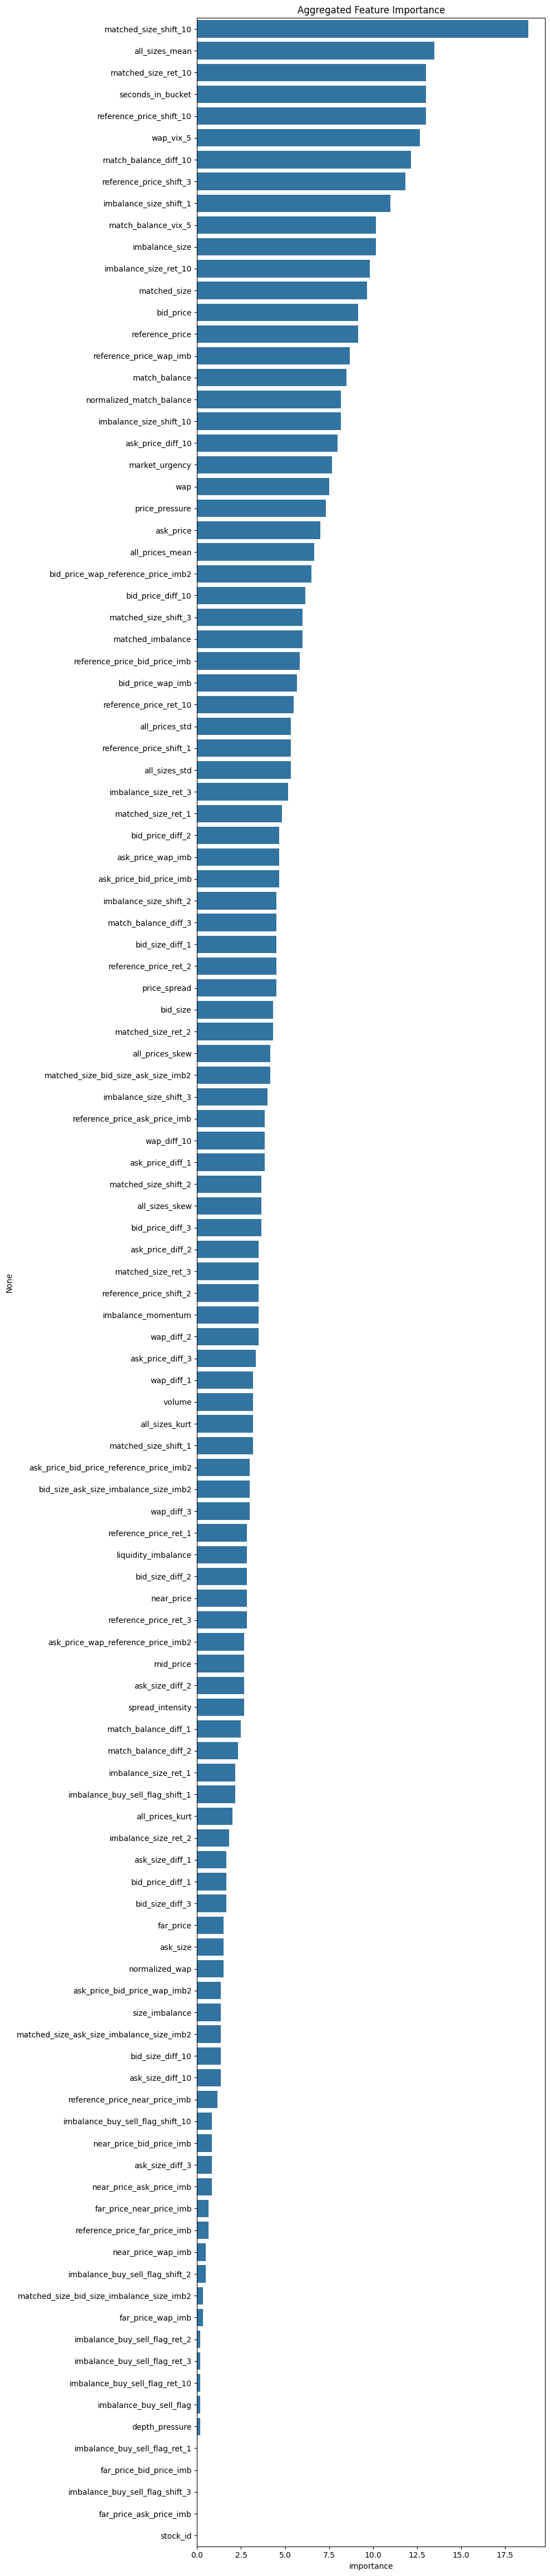

In [13]:
# Plot
fig, ax = plt.subplots(figsize=(10, len(feature_name) * 0.4))  # Adjust the size accordingly
sns.barplot(x='importance', y=aggregated_importance.index, data=aggregated_importance, ax=ax)
ax.set_title('Aggregated Feature Importance')
plt.tight_layout()
plt.show()

# Infer

In [15]:
# 📉 Define a function to adjust prices based on volumes
def zero_sum(prices, volumes):
    std_error = np.sqrt(volumes)  # 🧮 Calculate standard error based on volumes
    step = np.sum(prices) / np.sum(std_error)  # 🧮 Calculate the step size based on prices and standard error
    out = prices - std_error * step  # 💰 Adjust prices by subtracting the standardized step size
    return out

# ℹ️ If in inference mode, use the Optiver 2023 environment
if IS_INFER:
    if IS_LOCAL:
        env = make_env()
    else:
        import optiver2023
        env = optiver2023.make_env()
    iter_test = env.iter_test()
    counter = 0
    y_min, y_max = -64, 64
    qps, predictions = [], []
    cache = pd.DataFrame()

    # 🚂 Define weights for each fold model
    model_weights = [1/len(models)] * len(models) 
    
    # 🔄 Loop through each test scenario
    for (test, revealed_targets, sample_prediction) in iter_test:
        now_time = time.time()
        cache = pd.concat([cache, test], ignore_index=True, axis=0)
        
        # 🔄 If not the first iteration, limit the cache to the last 21 rows for each stock
        if counter > 0:
            cache = cache.groupby(['stock_id']).tail(21).sort_values(by=['date_id', 'seconds_in_bucket', 'stock_id']).reset_index(drop=True)
        
        # 📊 Generate features based on the updated cache
        feat = generate_all_features(cache, False)[-len(test):]

        # 📊 Generate predictions for each model and calculate the weighted average
        lgb_predictions = np.zeros(len(test))
        for model, weight in zip(models, model_weights):
            lgb_predictions += weight * model.predict(feat)

        # 🧮 Adjust predictions using the zero_sum function
        lgb_predictions = zero_sum(lgb_predictions, test['bid_size'] + test['ask_size'])
        clipped_predictions = np.clip(lgb_predictions, y_min, y_max)  # 📏 Clip predictions within a specified range
        print(clipped_predictions.describe())
        break
        sample_prediction['target'] = clipped_predictions
        env.predict(sample_prediction)  # 📈 Submit predictions to the environment
        counter += 1
        qps.append(time.time() - now_time)
        
        # 🔄 Print the average queries per second every 10 iterations
        if counter % 10 == 0:
            print(counter, 'qps:', np.mean(qps))

    time_cost = 1.146 * np.mean(qps)
    print(f"The code will take approximately {np.round(time_cost, 4)} hours to reason about")


generate_normalized_features
use exsisting global_population
type
float64
The code will take approximately nan hours to reason about
